In [1]:
import re
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
columns = [u'cm_key', u'mvar2', u'mvar3', u'mvar4', u'mvar5', u'mvar6', u'mvar7', u'mvar8', u'mvar9', u'mvar10',
           u'mvar11', u'mvar12', u'mvar13', u'mvar14', u'mvar15', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
           u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', u'mvar30',
           u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', u'mvar39', u'mvar40',
           u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45', u'income_by_spending', u'membership_by_n',
           u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer', u'months_by_card',
           u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', 
           # u'accepted_by_extended_supp',u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
           u'avg_total', u'avg_sectors_quaters',
           u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
           u'other_spend_quater4_by_total', u'other_spend_by_total', u'membership_by_income',u'spending_by_income',
           u'income_by_family', u'spending_by_family', u'membership_by_family'

]
quantity_features = [
                    u'mvar3', u'mvar6', u'mvar9', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
                    u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', 
                    u'mvar30', u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', 
                    u'mvar39', u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer',
                    u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', u'avg_total', u'avg_sectors_quaters',
                    u'income_by_family', u'spending_by_family', u'membership_by_family'
]
ratio_features = [
                u'mvar7', u'mvar8', u'mvar11',
                u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
                u'other_spend_quater4_by_total', u'other_spend_by_total', u'months_by_card', 
                # u'accepted_by_extended_supp', u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
                u'income_by_spending', u'membership_by_n',u'membership_by_income',u'spending_by_income'
]
number_features = [
                 u'mvar13', u'mvar14', u'mvar15', u'mvar2', u'mvar4', u'mvar5', u'mvar40',
                 u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45'
]

categorical_columns = [u'mvar12', u'mvar10']
labels = pd.Series(train.target.values)
train = train[columns]
test = test[columns]

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in categorical_columns:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.fit_transform(test[feature])
ltr = len(train)
test_key = test.cm_key
data = pd.concat([train, test], axis = 0)
data.drop(['cm_key'], axis = 1, inplace = True)
del train
del test

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
# from scipy.stats import skew
# skewed = data[quantity_features].apply(lambda x: skew(x.dropna().astype(float)))
# skewed = skewed[skewed > 0.75]
# skewed = skewed.index
# data[skewed] = np.log1p(data[skewed])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[quantity_features])
scaled = scaler.transform(data[quantity_features])
for i, col in enumerate(quantity_features):
    data[col] = scaled[:,i]

train_data_df = data[:ltr]
test_data_df = data[ltr:]

del data

In [4]:
def printtofile(df, PROBABILITY_THRESHOLD):
    df.drop('0',1, inplace=True)
    filtr = lambda x: 1 if x > PROBABILITY_THRESHOLD else 0
    df['Credit'] = df['1'].apply(filtr)
    df['Elite'] = df['2'].apply(filtr)
    df['Supp'] = df['3'].apply(filtr)
    print df[['Credit', 'Elite', 'Supp']].values.sum()
    df['prob'] = df['1']*df['Credit'] + df['2']*df['Elite'] + df['3']*df['Supp']
    df['cm_key'] = range(50001, 50001+len(df))
    df.sort_values(['prob'], ascending=[False], inplace=True)
    df.drop(['1', '2', '3'],1, inplace=True)
    df['label_type'] = 6*df['Credit'] + 8*df['Elite'] + 10*df['Supp']
    lbl = lambda x: 'Credit' if x == 6 else ('Elite' if x == 8 else ('Supp' if x == 10 else 'Credit'))
    df['label'] = df['label_type'].apply(lbl)
    df.to_csv("results_randomForests.csv", index=False)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(
#                             max_features='sqrt', 
                            n_estimators=2000, 
                            min_samples_leaf=20,
                            n_jobs=-1,
                            oob_score=True,  #Cross Validation 
                            random_state=7, 
                            min_samples_split=15,
                            criterion='entropy',
                            #max_depth=5,   #No need to specify if min_samples_split is specified
                            bootstrap=True, 
                            min_weight_fraction_leaf=0.1,
                            max_leaf_nodes=320,
                            class_weight=None, 
                            verbose=1,
                            warm_start=False
                            )
# scores2 = cross_val_score(clf, train_data_df, labels, cv = 5)
clf.fit(train_data_df, labels)


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=320,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=15,
            min_weight_fraction_leaf=0.1, n_estimators=2000, n_jobs=-1,
            oob_score=True, random_state=7, verbose=1, warm_start=False)

In [39]:
print scores

[ 0.77793052  0.77793052  0.77809726  0.77809726  0.77819455]


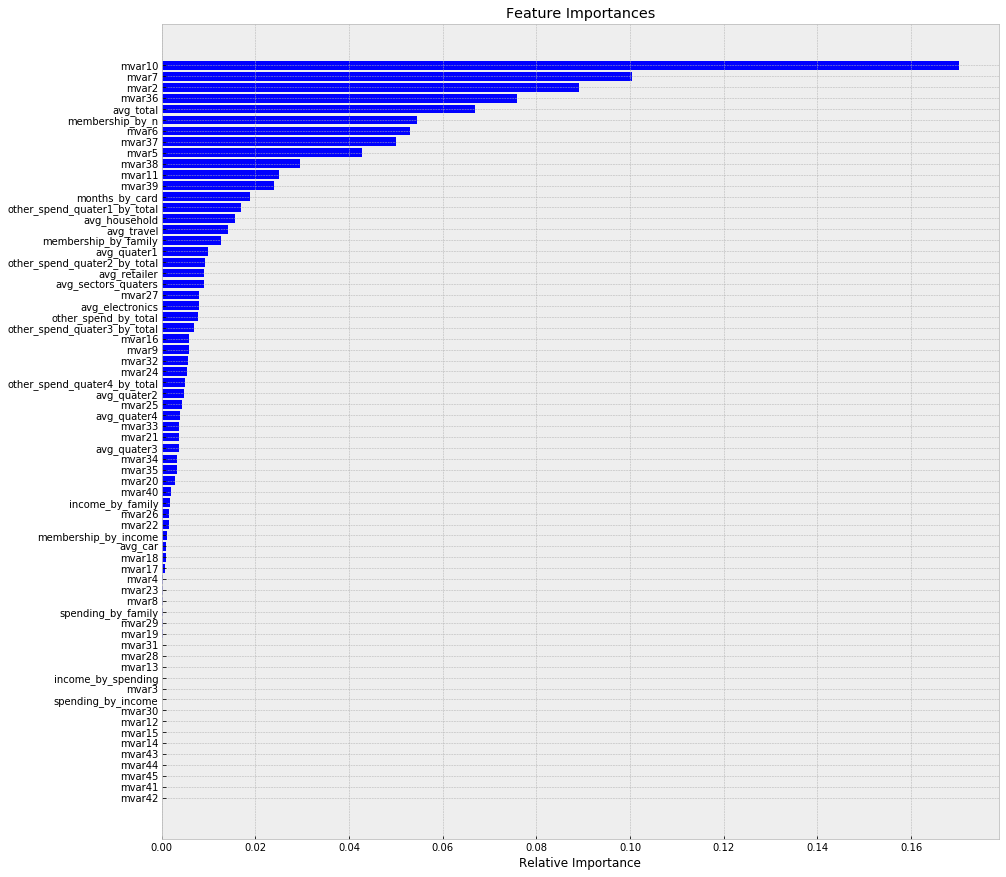

In [8]:
importances = clf.feature_importances_
indices = np.argsort(importances)
sets = plt.figure(1)
sets.set_size_inches(15, 15)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), train_data_df.columns[indices])
plt.xlabel('Relative Importance')

In [9]:
ypreds = clf.predict_proba(test_data_df)
submission = pd.DataFrame(ypreds, columns=['0','1','2','3'])
submission.to_csv("raw_results.csv")
printtofile(submission,0.14)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.8s finished


1034


#### Grid Search : To be tested yet

In [ ]:
param_grid = {"n_estimators": [1000, 1500],
              "max_depth": [3, 5],
              "min_samples_split": [10, 15, 20],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [10, 20, 40],
              "min_weight_fraction_leaf": [0.1]}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid = param_grid)
grid_search.fit(train_data_df, labels)

In [ ]:
df = {}
for i, score in enumerate(grid_search.grid_scores_):
    df[score[0][parameter]] = score[1]
df = pd.DataFrame.from_dict(df, orient='index')
df.reset_index(level=0, inplace=True)
df = df.sort_values(by='index')
print df